# Modelos preditivos para a área da Saúde

## Projeto 1: propensão a condição crítica de saúde

Uma empresa do ramo de saúde quer prever uma situação de saúde crítica de seus clientes no futuro, de modo a atuar de maneira preventiva com grupos de pessoas que possuem maior risco de desenvolver essa condição crítica. Seu trabalho enquanto cientista de dados será implementar um modelo de machine learning para resolver o problema.

### Dados e objetivo

Para isso foi disponibilizada uma base de dados com 50 mil casos, mil variáveis e um alvo (situação crítica 1, não crítica 0). Os dados estão divididos em uma base de [**Treino**](https://drive.google.com/file/d/1cBiizQ0ftP16dxqSQ8XVcf5oYIwEHkIU/view?usp=sharing) e outra de [**Teste**](https://drive.google.com/file/d/13AoBow1bEiAmmw9fqi0sv-QaoTciLiid/view?usp=sharing). Para resolver o desafio, é necessário desenvolver um modelo de classificação para prever a situação crítica de saúde, selecionando as variáveis que possuem maior relevância para o problema, de modo que só entrem em produção até 100 variáveis no máximo.

### Avaliação

Avalie seu modelo nas bases de treino e de teste, trazendo as métricas de Área Sob a Curva ROC, Matriz de Confusão, Taxa do Alvo no Decil 10 e Taxa do Alvo no Percentil 100 (ordene a base de teste pelo score, some o alvo real e divida pela quantidade de casos de acordo com o top 10% e top 1%, respectivamente). Além da análise técnica, faça uma avaliação de negócio, interpretando os números obtidos e indicando como o seu modelo de machine learning impactaria positivamente a empresa de saúde e seus clientes.

In [66]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [29]:
# Obtendo dataset
train_path = '../datasets/health/train.gz'
test_path = '../datasets/health/test.gz'

train_data = pd.read_csv(train_path, compression='gzip')
test_data = pd.read_csv(test_path, compression='gzip')

## Análise exploratória dos dados
Observações:
 - Proporção treino e teste 80% e 20%, respectivamente
 - Presença de missing values em todas as váriaveis (exceto na 'var1000'), proporcionais por váriavel nos dados de treino e teste
 - Presença de desbalanceamento dos dados no dataset de treino, cerca de 86.41% de dados de clientes em situação não critica e apenas 13.58% de dados de clientes em situação crítica

In [3]:
train_data.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,2142.0,4397.0,8978.0,17329.0,25324.0,1515.0,3053.0,6295.0,12179.0,17714.0,...,0.00,0.00,0.00,0.00,0.00,0.00,3849.11,1.0,0,0
1,4230.0,8477.0,16253.0,31545.0,46576.0,3151.0,6286.0,12021.0,23391.0,34501.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
2,123016.0,253889.0,479469.0,949783.0,1423562.0,84625.0,173262.0,327248.0,648115.0,971543.0,...,2872.32,2872.32,1217.18,12423.70,21092.96,35177.31,66642.75,13.0,0,0
3,7646.0,15987.0,31309.0,60711.0,88139.0,5760.0,11899.0,23219.0,45452.0,66126.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
4,5442.0,10358.0,20710.0,40147.0,61672.0,1940.0,3900.0,7825.0,15161.0,22792.0,...,1045782.67,1645343.02,245300.63,514644.76,1628928.12,3211634.36,6019027.97,3940.0,0,0


In [4]:
test_data.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
1,1833.0,3745.0,3745.0,3745.0,3745.0,1314.0,2619.0,2619.0,2619.0,2619.0,...,0.00,0.00,199.33,944.33,1602.42,1602.42,1602.42,3.0,0,0
2,5077.0,10747.0,19337.0,35050.0,49748.0,3740.0,7885.0,14069.0,25651.0,36413.0,...,0.00,0.00,0.00,0.00,0.00,4925.56,4925.56,1.0,0,0
3,6145.0,12540.0,24752.0,49255.0,73599.0,3120.0,6436.0,12530.0,24554.0,36307.0,...,957.44,24444.31,0.00,0.00,0.00,123870.68,193836.09,40.0,0,0
4,12766.0,25627.0,41590.0,41590.0,41590.0,8516.0,17013.0,27721.0,27721.0,27721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 305.5 MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 76.4 MB


In [11]:
train_data.isnull().sum().value_counts()

3363     653
2793     261
5262      30
7270      26
18418     12
13453      9
6491       4
9238       3
0          2
16686      1
dtype: int64

In [10]:
test_data.isnull().sum().value_counts()

826     653
693     261
1287     30
1825     26
4671     12
3394      9
1609      4
2297      3
0         2
4158      1
dtype: int64

In [5]:
train_data.describe()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
count,36637.000000,36637.000000,36637.000000,3.663700e+04,3.663700e+04,36637.000000,36637.000000,36637.000000,36637.000000,3.663700e+04,...,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,34738.000000,40000.000000,40000.000000
mean,24804.687120,49974.286077,95779.201245,1.818178e+05,2.600089e+05,16658.785244,33521.751372,64056.096733,121855.235472,1.743171e+05,...,4.770847e+04,7.842249e+04,2.003598e+04,6.003429e+04,1.159118e+05,2.166463e+05,4.057985e+05,289.617710,0.135875,0.135875
std,44358.395291,89772.486759,171980.581801,3.309234e+05,4.809253e+05,30717.882674,61978.170719,118550.902344,229214.621624,3.337036e+05,...,2.494814e+05,3.922620e+05,8.813214e+04,2.492367e+05,4.767993e+05,8.833351e+05,1.663978e+06,1180.215142,0.342660,0.342660
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3359.000000,6590.000000,12499.000000,2.365000e+04,2.820100e+04,1970.000000,4015.000000,7752.000000,14041.000000,1.971000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.150250e+02,0.000000,0.000000,0.000000
50%,6143.000000,12265.000000,23529.000000,4.541100e+04,6.599600e+04,3208.000000,6348.000000,12454.000000,23916.000000,3.364300e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.976200e+02,2.729775e+03,7.455045e+03,3.000000,0.000000,0.000000
75%,10252.000000,20319.000000,39658.000000,7.639400e+04,1.097320e+05,6750.000000,13272.000000,25178.000000,47365.000000,6.765400e+04,...,2.872320e+03,7.180800e+03,7.190925e+02,4.255587e+03,1.028444e+04,2.067908e+04,4.031233e+04,14.000000,0.000000,0.000000
max,168919.000000,316033.000000,563161.000000,1.054178e+06,1.535014e+06,112720.000000,214210.000000,379438.000000,714427.000000,1.042131e+06,...,7.830240e+06,1.116868e+07,2.015612e+06,5.905256e+06,1.300342e+07,2.058648e+07,5.032083e+07,20502.000000,1.000000,1.000000


In [6]:
test_data.describe()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
count,9174.000000,9174.000000,9174.000000,9.174000e+03,9.174000e+03,9174.000000,9174.000000,9174.000000,9174.000000,9.174000e+03,...,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8713.000000,10000.000000,10000.000000
mean,24864.573578,50174.079355,95576.022346,1.809401e+05,2.582955e+05,16707.490517,33660.392522,63913.747002,121248.619468,1.731504e+05,...,4.616771e+04,7.549891e+04,1.942765e+04,5.794069e+04,1.108083e+05,2.054263e+05,3.862228e+05,273.882360,0.135900,0.135900
std,44469.720558,90183.189076,171736.914031,3.300074e+05,4.790643e+05,30806.337294,62239.910301,118328.888769,228504.537154,3.323184e+05,...,2.481162e+05,3.916968e+05,9.048858e+04,2.484163e+05,4.636473e+05,8.463317e+05,1.598387e+06,1135.406673,0.342699,0.342699
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3359.500000,6590.000000,12519.000000,2.377100e+04,2.820100e+04,2000.000000,4072.000000,7752.000000,14442.000000,1.987900e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.475100e+02,0.000000,0.000000,0.000000
50%,6143.000000,12341.000000,23739.000000,4.542800e+04,6.618300e+04,3237.000000,6374.000000,12484.000000,24113.000000,3.416600e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.150000e+02,2.948350e+03,7.647040e+03,3.000000,0.000000,0.000000
75%,10291.000000,20363.000000,39496.000000,7.633675e+04,1.084432e+05,6750.000000,13940.000000,25187.000000,47410.750000,6.765200e+04,...,3.051780e+03,7.180800e+03,6.881100e+02,4.205480e+03,1.018238e+04,2.069721e+04,4.074355e+04,14.000000,0.000000,0.000000
max,168919.000000,316033.000000,563161.000000,1.054178e+06,1.535014e+06,112720.000000,214210.000000,379438.000000,714427.000000,1.042131e+06,...,5.717874e+06,1.075274e+07,2.015612e+06,4.872254e+06,9.299266e+06,1.809810e+07,3.569716e+07,16877.000000,1.000000,1.000000


In [20]:
grouped_target = train_data.groupby(train_data.alvo)
print(grouped_target.get_group(0).info())
print(grouped_target.get_group(1).info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34565 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 264.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5435 entries, 12 to 39993
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 41.5 MB
None


## Pré-processamento das variáveis
Durante esta etapa, estarei lidando com o desbalanceamento dos dados de treino

In [30]:
def preprocess(balance_train_fn, fill_missing_data_fn):
    new_train = fill_missing_data_fn(train_data)
    new_test = fill_missing_data_fn(test_data)
    balanced_train = balance_train_fn(new_train)

    train_y = balanced_train['alvo']
    test_y = new_test['alvo']
    train_X = balanced_train.drop('alvo', axis=1)
    test_X = new_test.drop('alvo', axis=1)
    return train_X, train_y, test_X, test_y


### Lidando com desbalanceamento de dados de treino
 - **Oversampling**: Replicando os dados da classe minoritária até que esteja maior ou igual ao da classe majoritária, e removendo o excesso no final para que tenham o mesmo tamanho
    - Escolhi usar esta abordagem com base no escopo e tempo do projeto, por ser uma abordagem **direta e rápida de ser executada**. Em outros contextos, abordagens como a coleta de mais dados da classe minoritária, ou geração de novos exemplos sintéticos poderiam ser úteis.

In [31]:
def oversampling(train):
    # Separação das classes
    grouped_target = train.groupby(train.alvo)
    non_critical = grouped_target.get_group(0)
    critical = grouped_target.get_group(1)

    # Duplicação da classe minoritaria
    while critical.shape[0] < non_critical.shape[0]:
        critical = pd.concat([critical,critical])
    critical = critical.iloc[:-(critical.shape[0]-non_critical.shape[0])]

    # Juntando as duas classes novamente e embaralhando
    train = pd.concat([non_critical, critical])
    train = train.sample(frac=1).reset_index(drop=True) 
    return train

### Preenchimento de missing values

In [32]:
def fill_mean(data):
    df_filled = data.fillna(data.mean())
    return df_filled

In [68]:
def fill_kNN(data):
    imputer = KNNImputer(n_neighbors=5)
    filled = imputer.fit_transform(data)
    df_filled = pd.DataFrame(filled, columns = data.columns)
    return df_filled

In [69]:
train_X, train_y, test_X, test_y = preprocess(oversampling, fill_kNN)

In [70]:
train_X.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var991,var992,var993,var994,var995,var996,var997,var998,var999,var1000
0,5975.0,12137.0,22983.0,44412.0,64817.0,4436.0,9027.0,17135.0,33141.0,48293.0,...,171768.26,477538.98,883086.540,182080.350,489093.920,896726.300,1824178.060,3537279.500,2643.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0
2,30531.4,62662.0,118432.2,232836.2,345971.2,20738.2,42296.2,79782.0,156795.8,232786.8,...,0.00,1352.38,1448.124,251.152,466.402,1979.778,6510.576,15931.206,5.8,0.0
3,6395.0,12584.0,24716.0,49288.0,73319.0,3316.0,6448.0,12457.0,24372.0,36037.0,...,0.00,0.00,0.000,0.000,0.000,0.000,6172.790,25554.490,17.0,1.0
4,138054.0,301391.0,563161.0,1054178.0,1535014.0,95285.0,206823.0,379438.0,714427.0,1042131.0,...,0.00,0.00,0.000,1160.450,2593.540,5715.480,9425.490,17392.900,12.0,1.0


### Salvando versões do conjunto de treino preenchidas por KNN devido a tempo do projeto

In [71]:
train_X.to_csv('knnFilledTrainX.csv')

In [76]:
test_X.to_csv('knnFilledTestX.csv')

## Seleção de features

In [88]:
def get_top_important_features(model):
    model.fit(train_X, train_y)

    # Obtendo as importâncias das variáveis
    importances = model.feature_importances_
    # Ordena as features importantes e filtra pelas importancias maiores que 0
    sorted_important_features = sorted(zip(train_X.columns, importances), key=lambda x: x[1], reverse=True)
    important_features_zip = filter(lambda x: x[1] > 0, sorted_important_features)

    important_features = [x[0] for x in important_features_zip][:100]
    print(important_features)
    print(len(important_features))
    return important_features

In [73]:
# Separando 20% do dataset (25% do dataset de treino para validação)
val_frac = 0.25

In [84]:
model_gb = GradientBoostingClassifier(validation_fraction=val_frac)
selected_features_gb = get_top_important_features(model_gb)

# Aplicando features importantes para o modelo gb
train_gb_X = train_X[selected_features_gb]

['var1000', 'var108', 'var948', 'var299', 'var880', 'var494', 'var716', 'var128', 'var704', 'var594', 'var983', 'var193', 'var657', 'var769', 'var587', 'var750', 'var447', 'var537', 'var4', 'var157', 'var300', 'var30', 'var710', 'var229', 'var34', 'var283', 'var281', 'var294', 'var278', 'var553', 'var492', 'var542', 'var913', 'var291', 'var795', 'var738', 'var706', 'var996', 'var595', 'var875']
40


In [89]:
model_rf = RandomForestClassifier()
selected_features_rf = get_top_important_features(model_rf)

# Aplicando features importantes para o modelo rf
train_rf_X = train_X[selected_features_rf]

['var1000', 'var575', 'var970', 'var574', 'var333', 'var988', 'var332', 'var573', 'var998', 'var334', 'var978', 'var983', 'var716', 'var975', 'var701', 'var706', 'var331', 'var696', 'var693', 'var572', 'var987', 'var997', 'var721', 'var982', 'var725', 'var718', 'var974', 'var705', 'var999', 'var972', 'var977', 'var700', 'var715', 'var579', 'var695', 'var986', 'var577', 'var587', 'var981', 'var724', 'var717', 'var692', 'var996', 'var720', 'var976', 'var691', 'var985', 'var973', 'var993', 'var971', 'var995', 'var704', 'var714', 'var699', 'var719', 'var980', 'var694', 'var723', 'var578', 'var586', 'var576', 'var713', 'var703', 'var992', 'var698', 'var711', 'var979', 'var984', 'var994', 'var710', 'var585', 'var991', 'var712', 'var702', 'var584', 'var697', 'var349', 'var605', 'var394', 'var368', 'var593', 'var709', 'var737', 'var990', 'var588', 'var583', 'var362', 'var753', 'var722', 'var393', 'var339', 'var590', 'var606', 'var450', 'var411', 'var371', 'var602', 'var603', 'var404', 'var708'

## Treinamento

In [94]:
model_gb.fit(train_gb_X, train_y)

GradientBoostingClassifier(validation_fraction=0.25)

In [90]:
model_rf.fit(train_rf_X, train_y)

RandomForestClassifier()

## Análise de resultados

In [91]:
def print_confusion_matrix(cm):
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5, 5), cmap='Greys', show_absolute=True, show_normed=True)
  ax.set_title("Matriz de Confusão")
  plt.show()

In [92]:
def print_results(model, trans_train_X, trans_test_X):
    train_predict_proba = model.predict_proba(trans_train_X)[:, 1]
    test_predict_proba = model.predict_proba(trans_test_X)[:, 1]
    
    # Métrica: Área Sob a Curva ROC
    roc_auc_train = roc_auc_score(train_y, train_predict_proba)
    print("Área Sob a Curva ROC (Treino):", roc_auc_train)
    roc_auc_test = roc_auc_score(test_y, test_predict_proba)
    print("Área Sob a Curva ROC (Teste):", roc_auc_test)

    # Métrica: Matriz de Confusão
    train_cm = confusion_matrix(train_y, train_predict_proba > 0.5)
    print_confusion_matrix(train_cm)
    test_cm = confusion_matrix(test_y, test_predict_proba > 0.5)
    print_confusion_matrix(test_cm)

    # Cálculo da Taxa do Alvo no Decil 10 e Percentil 100
    sorted_test_score = np.argsort(test_predict_proba)[::-1]

    target_rate_decile_10 = np.mean(test_y[sorted_test_score[:len(test_y)//10]])
    print("Taxa do Alvo no Decil 10:", target_rate_decile_10)
    target_rate_percentile_100 = np.mean(test_y[sorted_test_score[:len(test_y)//100]])   
    print("Taxa do Alvo no Percentil 100:", target_rate_percentile_100)

1.0
1.0
Área Sob a Curva ROC (Treino): 1.0
Área Sob a Curva ROC (Teste): 1.0


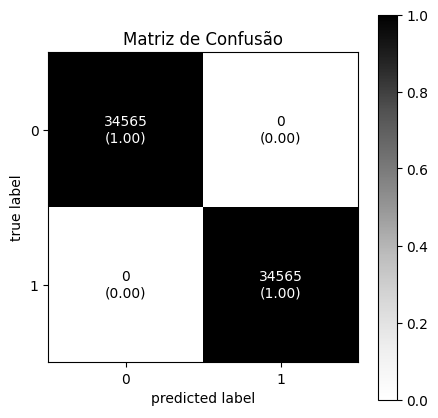

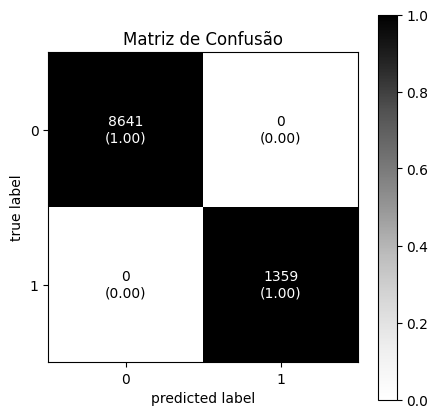

Taxa do Alvo no Decil 10: 1.0
Taxa do Alvo no Percentil 100: 1.0


In [95]:
test_gb_X = test_X[selected_features_gb]
print(model_gb.score(train_gb_X, train_y))
print(model_gb.score(test_gb_X, test_y))
print_results(model_gb, train_gb_X, test_gb_X)

1.0
1.0
Área Sob a Curva ROC (Treino): 1.0
Área Sob a Curva ROC (Teste): 1.0


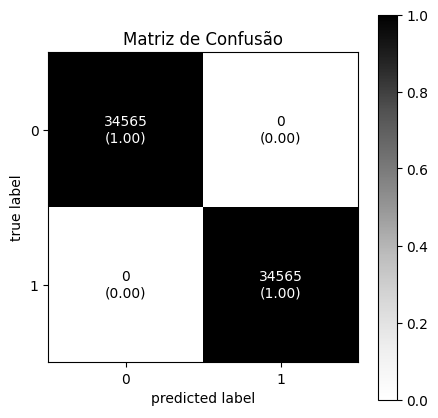

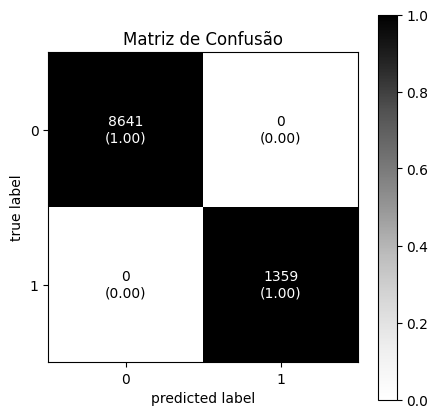

Taxa do Alvo no Decil 10: 1.0
Taxa do Alvo no Percentil 100: 1.0


In [96]:
test_rf_X = test_X[selected_features_rf]
print(model_rf.score(train_rf_X, train_y))
print(model_rf.score(test_rf_X, test_y))
print_results(model_rf, train_rf_X, test_rf_X)